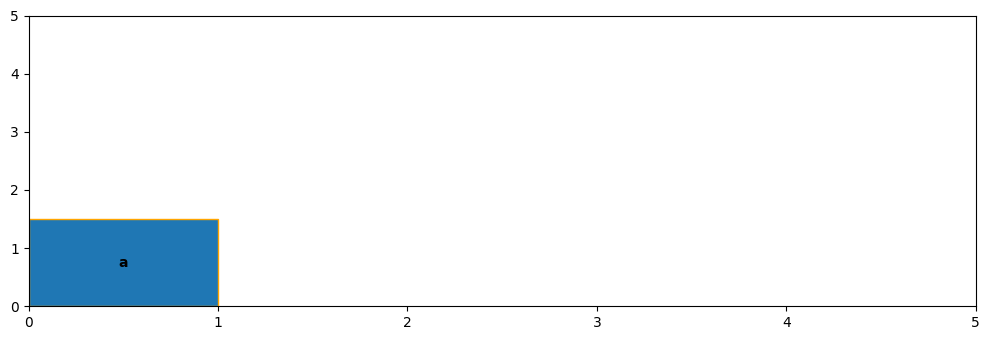

In [1]:
#helper functions to visualize the stack and the input string
from matplotlib import pyplot as plt, patches
plt.rcParams["figure.figsize"] = [10.00, 3.50]
plt.rcParams["figure.autolayout"] = True
fig = plt.figure()
ax = fig.add_subplot(111)
size2=1 # for descendent
size2=1.5#ascendent
def addBox(x,y,text, fill=True, size=1):
  rectangle = patches.Rectangle((x, y), size, size2, edgecolor='orange', fill=fill)
  ax.add_patch(rectangle)
  cx = x + rectangle.get_width()/2.0
  cy = y + rectangle.get_height()/2.0
  ax.annotate(text, (cx, cy), color='black', weight='bold', fontsize=10, ha='center', va='center')
addBox(0,0,"a")
plt.xlim([0, 5])
plt.ylim([0, 5])
plt.show()

In [2]:
class Prod():
  def __init__(self, left, right):
    self.left = left
    self.right = right

  def __str__(self):
    return f"{self.left} -> {' '.join(self.right)}"

class stack():
  def __init__(self):
    self.list = []
  def push(self,e):
    if e != "eps":
      self.list.append(e)
  def pop(self):
    return self.list.pop()
  def isempty(self):
    return self.list ==[]
  def is_end(self):
    return self.list == ["#"]
  def top(self):
    return self.list[-1]
  def __str__(self):
    return " ".join(self.list[::-1])
  def draw(self, step):
    for i,e in enumerate(self.list):
      addBox(step*2,i, e)

**Table driven predictive parsing**

In [17]:
prod = [ Prod("E", ["T", "E'"]),
             Prod("E'", ["+", "T", "E'"]), Prod("E'", ["eps"]),
             Prod("T", ["F", "T'"]),
             Prod("T'", ["*", "F", "T'"]), Prod("T'", ["eps"]),
             Prod("F", ["i"]), Prod("F", ["(", "E", ")"])]

In [18]:
#print productions
for p in prod:
  print(f"{p}")

E -> T E'
E' -> + T E'
E' -> eps
T -> F T'
T' -> * F T'
T' -> eps
F -> i
F -> ( E )


In [19]:
terminal = ["i", "+", "*", "(", ")"]
nonterminal = ["E", "E'", "T", "T'", "F"]

In [20]:
table = { "E":  {"i" : prod[0], "(": prod[0]},
          "E'": {"+" : prod[1], ")" : prod[2], "#": prod[2]},
          "T" : {"i" : prod[3], "(" : prod[3]},
          "T'": {"+" : prod[5], "*" : prod[4], ")": prod[5], "#": prod[5]},
          "F" : {"i" : prod[6], "(" : prod[7]}}

In [22]:
#only for pretty printing
table_for_pp = []
for nont in nonterminal:
  line = [table[nont][t] if t in table[nont].keys() else ""  for t in terminal+["#"]]
  table_for_pp.append([nont]+line)

from tabulate import tabulate
print("Table for Table driven parsing")
print(tabulate(table_for_pp, headers = terminal + ["#"]))


Table for Table driven parsing
    i          +             *             (           )          #
--  ---------  ------------  ------------  ----------  ---------  ---------
E   E -> T E'                              E -> T E'
E'             E' -> + T E'                            E' -> eps  E' -> eps
T   T -> F T'                              T -> F T'
T'             T' -> eps     T' -> * F T'              T' -> eps  T' -> eps
F   F -> i                                 F -> ( E )


Tracing of Table driven parsing for *input*

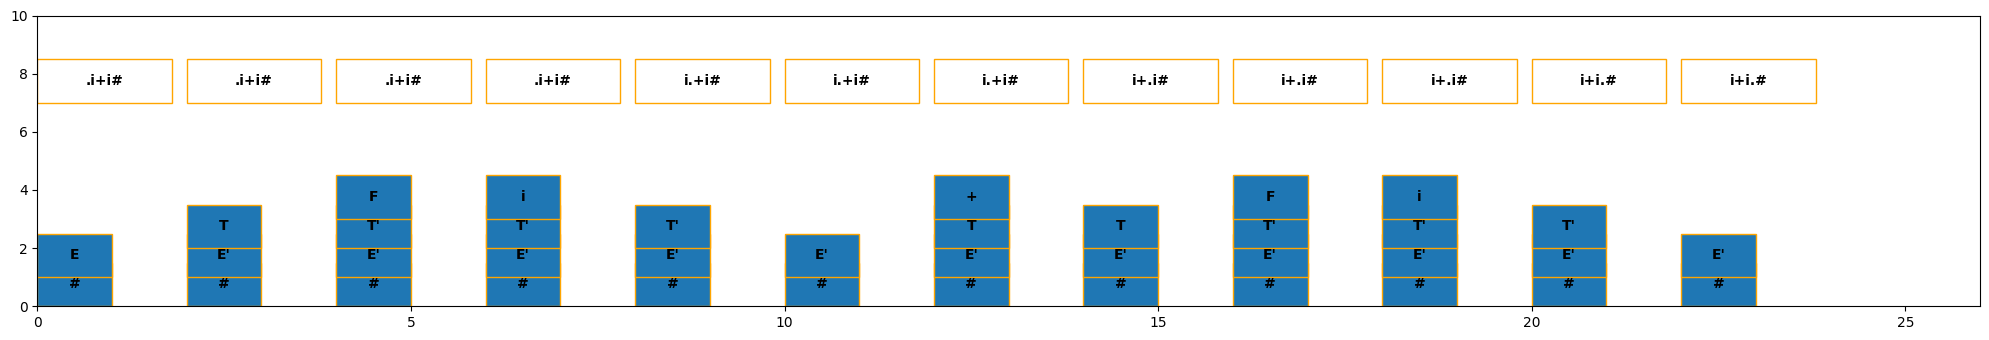

In [23]:
fig = plt.figure()
ax = fig.add_subplot(111)

debug = False
st = stack()
st.push("#")
st.push("E")

input = "i+i#"
i = 0

step=0
while True:
  st.draw(step)
  addBox(2*step,7, input[:i]+"."+input[i:], fill=False, size=1.8)
  step +=1
  X = st.top()
  print(f"The top of the stack is {X}") if debug else None
  if X in terminal or X =="#":
    print("The top of the stack is a terminal, we either consume, either raise an error") if debug else None
    if input[i] == X:
      print(f"We consume {input[i]}") if debug else None
      st.pop()
      i=i+1
    else:
      print(f"Error at {input[:i]}\n Expected {X}, found {input[i]}")
      break
  else:
    if input[i] in table[X].keys():
      st.pop()
      rule = table[X][input[i]]
      right = rule.right.copy()
      right.reverse()
      for e in right:
        st.push(e)
      print(f"The applied production: {rule}. The stack is now : {st}") if debug else None
    else:
      print(f"Error at {input[:i]}. We predict an {X}. \n Expected one of {list(table[X].keys())}, found {input[i]}")
      break
  if st.is_end():
    break

plt.xlim([0, (step+1)*2])
plt.ylim([0, 10])
plt.show()

In [10]:
print(tabulate(table_for_pp, headers = terminal + ["#"]))


    i          +             *             (           )          #
--  ---------  ------------  ------------  ----------  ---------  ---------
E   E -> T E'                              E -> T E'
E'             E' -> + T E'                            E' -> eps  E' -> eps
T   T -> F T'                              T -> F T'
T'             T' -> eps     T' -> * F T'              T' -> eps  T' -> eps
F   F -> i                                 F -> ( E )


**Automat - Sistem de rescriere - strong LL(1)**

Gramatica: E -> E + F | F, F -> i | (E)

Dupa eliminarea recursivitatii stanga si introducerea nonterminalului cu o singura productie:

Z-> E, E -> FE1, E ->epsilon | +FE1, F->i | (E)



In [24]:
states = {"q0": "[Z->.E]",    "q8":"[E1 -> .+FE1]",
          "q1": "[Z->E.]",    "q9":"[F->i.]",
          "q2": "[E->.FE1]",   "q10":"[F->(.E)]",
          "q3": "[E->F.E1]",   "q11":"[E1->+.FE1]",
          "q4": "[F->.i]",     "q12": "[F->(E.)]",
          "q5": "[F->.(E)]",   "q13":"[E1->+F.E1]",
          "q6": "[E->FE1.]",   "q14" :"[F->(E).]",
          "q7": "[E1->eps]" ,   "q15": "[E1->+FE1.]"}

In [25]:
class ProdA():
  def __init__(self, left, right):
    self.left = left
    self.right = right

  def __str__(self):
    return f"{' '.join(self.left)} -> {' '.join(self.right)}"

prodA = [ ProdA(["q0", "i"], ["q1", "q2", "i"]),  ProdA(["q0", "("], ["q1", "q2", "("]),
          ProdA(["q1"], ["eps"]),
         ProdA(["q2", "i"], ["q3", "q4", "i"]),   ProdA(["q2", "("], ["q3", "q5", "("]),
         ProdA(["q3", "#"], ["q6", "q7", "#"]),   ProdA(["q3", ")"], ["q6", "q7", ")"]),   ProdA(["q3", "+"], ["q6", "q8", "+"]),
         ProdA(["q4", "i"], ["q9"]),
         ProdA(["q5", "("], ["q10"]),
         ProdA(["q6"], ["eps"]),
         ProdA(["q7"], ["eps"]),
         ProdA(["q8", "+"], ["q11"]),
         ProdA(["q9"], ["eps"]),
          ProdA(["q10", "i"], ["q12", "q2", "i"]),  ProdA(["q10", "("], ["q12", "q2", "("]),
          ProdA(["q11", "i"], ["q13", "q4", "i"]),  ProdA(["q11", "("], ["q13", "q5", "("]),
         ProdA(["q12", ")"], ["q14"]),
         ProdA(["q13", "#"], ["q15", "q7", "#"]),   ProdA(["q13", ")"], ["q15", "q7", ")"]),   ProdA(["q13", "+"], ["q15", "q8", "+"]),
         ProdA(["q14"], ["eps"]),
         ProdA(["q15"], ["eps"])]

In [26]:
for p in prodA:
  print(f"{p}")

q0 i -> q1 q2 i
q0 ( -> q1 q2 (
q1 -> eps
q2 i -> q3 q4 i
q2 ( -> q3 q5 (
q3 # -> q6 q7 #
q3 ) -> q6 q7 )
q3 + -> q6 q8 +
q4 i -> q9
q5 ( -> q10
q6 -> eps
q7 -> eps
q8 + -> q11
q9 -> eps
q10 i -> q12 q2 i
q10 ( -> q12 q2 (
q11 i -> q13 q4 i
q11 ( -> q13 q5 (
q12 ) -> q14
q13 # -> q15 q7 #
q13 ) -> q15 q7 )
q13 + -> q15 q8 +
q14 -> eps
q15 -> eps


In [27]:
def getApplicProd(to_derive_string):
  applicable_prods = [p for p in prodA \
                      if p.left in [to_derive_string[i:i+len(p.left)] \
                                    for i in range(len(to_derive_string)-1) if to_derive_string[i+1] in terminal + ["#"]]]
  if len(applicable_prods)>1:
    print(f"More than one productions can be applied: {applicable_prods[0]}, {applicable_prods[1]}")
  return applicable_prods

def derive(to_derive_string, prod):
  #find index in to_derive_string where the left part of the production is present
  for i in range(len(to_derive_string)):
    if prod.left== to_derive_string[i:i+len(prod.left)]:
      break
  return to_derive_string[:i] + prod.right + to_derive_string[i+len(prod.left):] if prod.right !=["eps"] else to_derive_string[:i] + to_derive_string[i+len(prod.left):]

def drawStack(step, to_derive_string, with_detail=True):
  for i,e in enumerate(to_derive_string):
    if "q" not in e:
      break
  for j in range(i):
    if with_detail:
      addBox(2.25*step,j*size2, f"{to_derive_string[j]}={states[to_derive_string[j]]}", size = 2)
    else:
      addBox(2.25*step,j * size2, f"{to_derive_string[j]}", size = 2)
  addBox(2.25*step,10, "".join(to_derive_string[i:]), fill=False, size=1.8)

In [29]:
#example for application of ONE production
#stack_state_input = ["q0", "q0", "i", "+",  "#"]
stack_state_input = ["q0", "q0", "i",  "#"]
p = getApplicProd(stack_state_input)
print(p[0])
derive(stack_state_input, p[0])

q0 i -> q1 q2 i


['q0', 'q1', 'q2', 'i', '#']

['q0', 'q1', 'q2', 'i', '#']
['q0', 'q1', 'q3', 'q4', 'i', '#']
['q0', 'q1', 'q3', 'q9', '#']
['q0', 'q1', 'q3', '#']
['q0', 'q1', 'q6', 'q7', '#']
['q0', 'q1', 'q6', '#']
['q0', 'q1', '#']
['q0', '#']


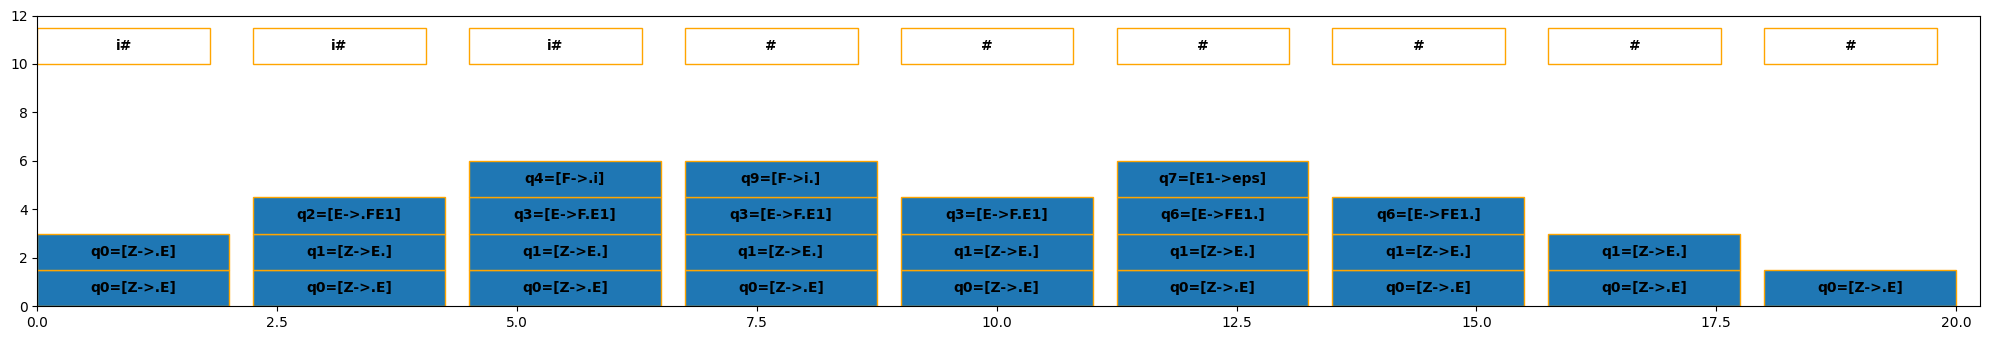

In [30]:
plt.rcParams["figure.figsize"] = [20.00, 3.50]
plt.rcParams["figure.autolayout"] = True
fig = plt.figure()
ax = fig.add_subplot(111)

stack_state_input = ["q0", "q0", "i",  "#"]
# stack_state_input = ["q0", "q0", "i", "+",  "i", "#"]
#stack_state_input = ["q0", "q0", "(", "i",  ")", "#"]
# stack_state_input = ["q0", "q0", "(", "i",   "#"]

drawStack(0, stack_state_input)
step=1
while True:
  applicable = getApplicProd(stack_state_input)
  if applicable == []:
    print("Reject the string")
    break

  stack_state_input = derive(stack_state_input, applicable[0] )
  print(stack_state_input)
  drawStack(step, stack_state_input)
  if stack_state_input ==["q0", "#"]:
    break
  step+=1
plt.xlim([0, (step+1)*2.25])
plt.ylim([0, 12])
plt.show()

Derivare Ascendenta LR(2)


In [ ]:
class ProdA():
  def __init__(self, left, right):
    self.left = left
    self.right = right

  def __str__(self):
    return f"{' '.join(self.left)} -> {' '.join(self.right)}"

def getApplicProd(to_derive_string):
  applicable_prods = [p for p in prodA \
                      if p.left in [to_derive_string[i:i+len(p.left)] \
                                    for i in range(len(to_derive_string)-1)]]# if to_derive_string[i+1] in terminal + ["#"]]]
  if len(applicable_prods)>1:
    print(f"More than one productions can be applied: {applicable_prods[0]}, {applicable_prods[1]}")
  return applicable_prods

In [ ]:
terminal = ["a", "b", "c"]

states = {"q0": "[Z->.X; #] [X->.Y;#] [X->.bYa;#] \n[Y->.c;#] [Y->.ca;#]",
          "q1": "[Z->X.;#]",
          "q2": "[X->Y.;#]",
          "q3": "[X->b.Ya;#] \n [Y->.c;a#][Y->.ca;a#]",
          "q4": "[Y->c.;#] [Y->c.a;#]",
          "q5": "[X->bY.a;#]",
          "q6": "[Y->c.;a#] [Y->c.a;a#]",
          "q7": "[Y-ca.;#]",
          "q8": "[X->bya.;#]",
          "q9": "[Y->ca.;a#]"}

In [ ]:
prodA = [ ProdA(["q0", "b", "c"], ["q0", "q3", "c"]),  ProdA(["q0", "c", "#"], ["q0", "q4", "#"]), ProdA(["q0", "c", "a"], ["q0", "q4", "a"]),

         ProdA(["q3", "c", "a"], ["q3", "q6", "a"]),
         ProdA(["q4", "a", "#"], ["q4", "q7", "#"]),
         ProdA(["q5", "a", "#"], ["q5", "q8", "#"]),
         ProdA(["q6", "a", "a"], ["q6", "q9", "a"]),
         ProdA(["q0", "q2", "#"], ["q0", "q1", "#"]),
         ProdA(["q0", "q4", "#"], ["q0", "q2", "#"]),
         ProdA(["q3", "q6", "a", "#"], ["q3", "q5", "a", "#"]),
         ProdA(["q0", "q4", "q7", "#"], ["q0", "q2", "#"]),
         ProdA(["q0", "q3", "q5", "q8", "#"], ["q0", "q1", "#"]),
         ProdA(["q3", "q6", "q9", "a", "#"], ["q3", "q5", "a", "#"]),
          ]

['q0', 'q4', 'a', '#']
['q0', 'q4', 'q7', '#']
['q0', 'q2', '#']
['q0', 'q1', '#']


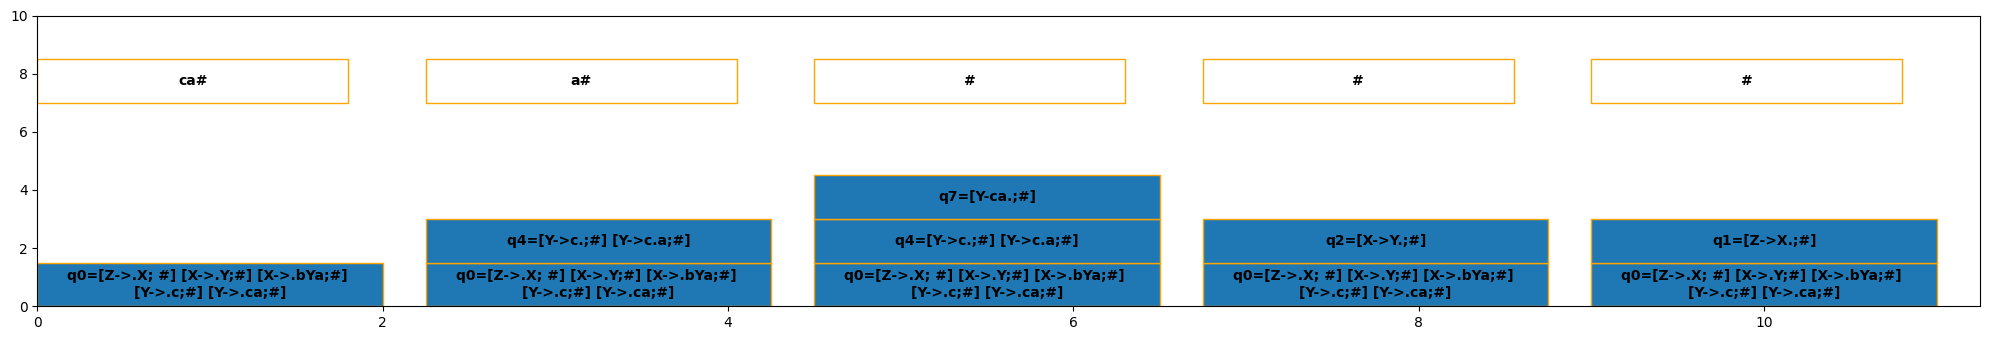

In [ ]:
plt.rcParams["figure.figsize"] = [20.00, 3.50]
plt.rcParams["figure.autolayout"] = True
fig = plt.figure()
ax = fig.add_subplot(111)

#stack_state_input = ["q0",   "b", "c", "a",  "a", "#"]
#stack_state_input = ["q0",   "b", "c", "a",  "#"]
stack_state_input = ["q0",   "c",  "a", "#"]

drawStack(0, stack_state_input)
step=1
while True:
  applicable = getApplicProd(stack_state_input)
  if applicable == []:
    print("Reject the string")
    break

  stack_state_input = derive(stack_state_input, applicable[0] )
  print(stack_state_input)
  drawStack(step, stack_state_input)
  if stack_state_input ==["q0", "q1", "#"]:
    break
  step+=1
plt.xlim([0, (step+1)*2.25])
plt.ylim([0, 10])
plt.show()